# Milestone 3 - First Model

In [1]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
from scripts import *
from first_scripts import *
from second_scripts import *
from tqdm import tqdm
import pickle as pkl
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import pairwise_distances_argmin


### I. Data Prepration

In [2]:
# Read the data
# data_path = './data'
data_path = './DLCV_SS25_Dataset'  
images, labels = data_reader(data_path)


In [3]:
num_classes = len(os.listdir(data_path))
num_classes

5

In [4]:
len(images)

2351

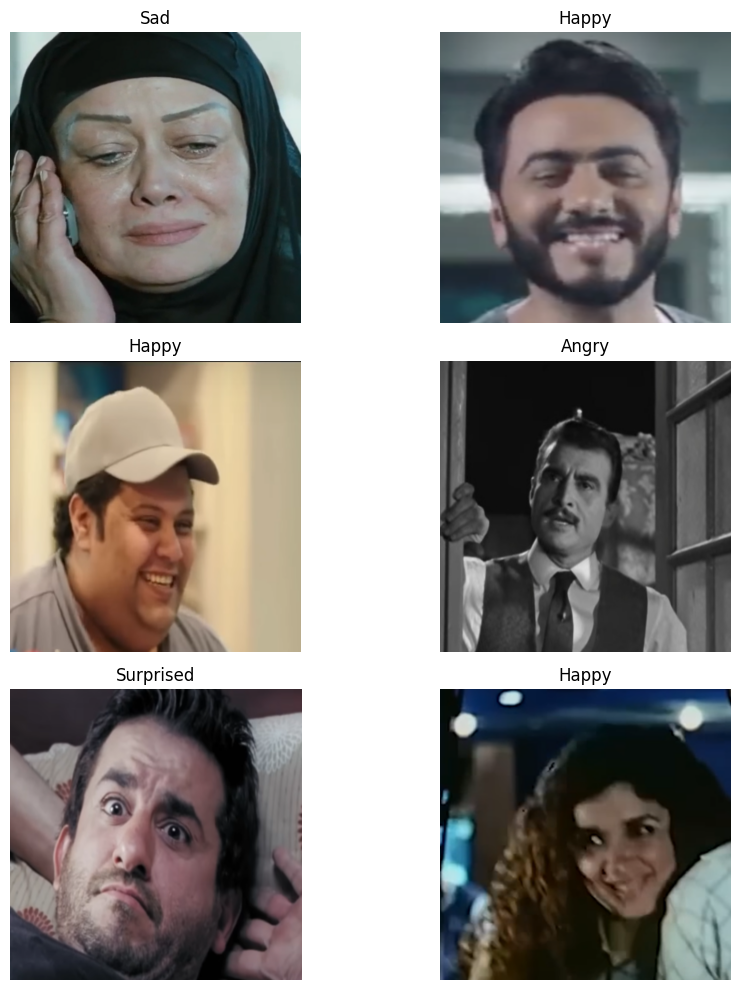

In [5]:
# View 4 random images and their titles
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    img = read_img(images[idx])
    ax.imshow(img)
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple, label_to_index = data_preperator((images, labels))
index_to_label = {v: k for k, v in label_to_index.items()}

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((1645,), (1645,), (470,), (470,), (236,), (236,))

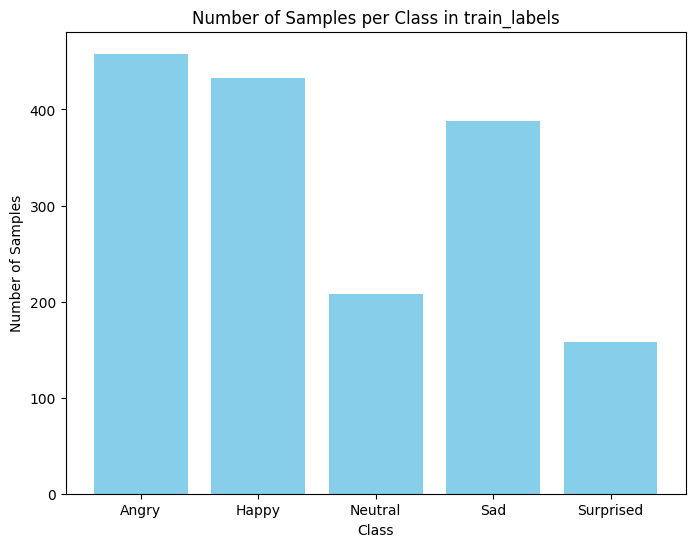

In [7]:
draw_barchart_labels(train_labels, label_to_index)

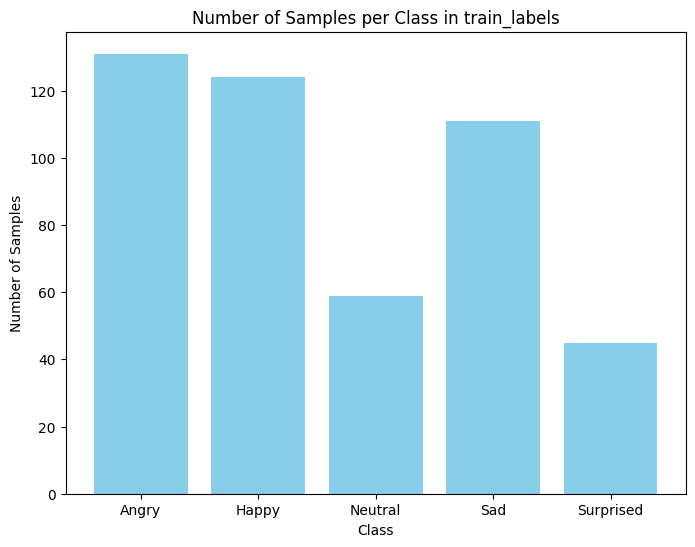

In [8]:
draw_barchart_labels(val_labels, label_to_index)

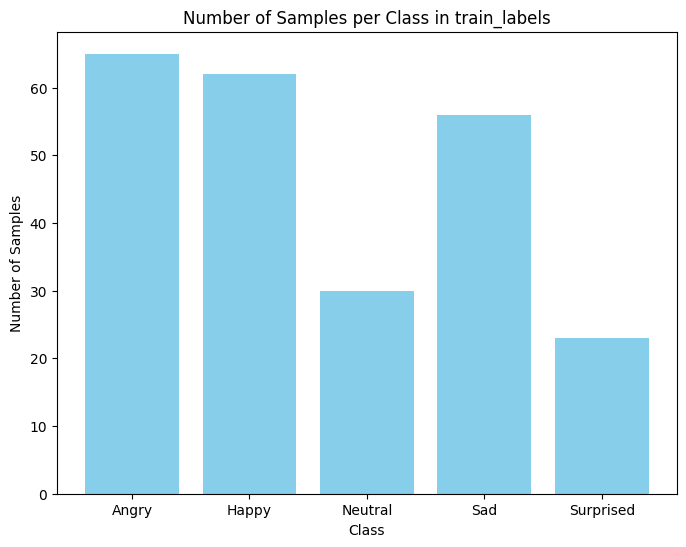

In [9]:
draw_barchart_labels(test_labels, label_to_index)

### II.First Model

In [10]:
# Predefined filters
import numpy as np

base_a = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

base_b = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

base_c = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

base_d = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

base_e = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

filter_a = np.stack([base_a]*3, axis=-1)
filter_b = np.stack([base_b]*3, axis=-1)
filter_c = np.stack([base_c]*3, axis=-1)
filter_d = np.stack([base_d]*3, axis=-1)
filter_e = np.stack([base_e]*3, axis=-1)


filters = [filter_a, filter_b, filter_c, filter_d, filter_e]

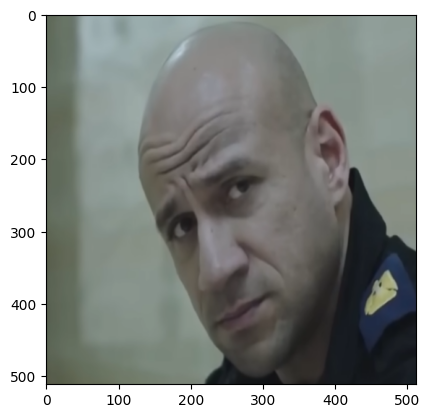

In [11]:
# Get example
path = train_data[0]
img = read_img(path)
# View img
plt.imshow(img) 

In [12]:
# Testing ConvLayer with Random filters
conv_layer = ConvLayer(4, (3, 3, 3))

output = conv_layer.forward(img)
output.shape

(510, 510, 4)

In [13]:
random_arr = np.random.rand(3, 3, 3)
random_arr_2 = np.random.rand(3, 3, 3)
np.dot(random_arr.flatten(), random_arr_2.flatten())

7.035138435545211

In [14]:
# Visualize the output of the convolutional layer
conv_layer = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=False)

output = conv_layer.forward(img)
output.shape

(510, 510, 5)

In [15]:
# Check if fast conv and normal conv are the same
conv_layer_fast = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=True)
output_fast = conv_layer_fast.forward(img)
conv_layer_normal = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=False)
output_normal = conv_layer_normal.forward(img)
print(f"Are the outputs the same? {np.equal(output_fast, output_normal).all()}")

Are the outputs the same? True


In [16]:
# Testing the pooling layer
pooling_layer = PoolingLayer(pooling_type='MAX', pool_size=(2, 2))

output = pooling_layer.forward(img)
output.shape

(256, 256, 3)

#### Use Predefined Filters

In [24]:
def extract_features(images_paths: list, model_path: str, use_predefined_filters: bool=True) -> np.ndarray:
    """
    Extract features from the images using the FirstModel.
    Args:
        data (list): List of image paths.
        model_path (str): Path to the model weights.
        use_predefined_filters (bool): Whether to use predefined filters or random ones.
    Returns:
        np.ndarray: Extracted features.
    """
    first_model = FirstModel(use_predefined_filters=use_predefined_filters)
    at_once = 20
    output = []
    for i in tqdm(range(0, len(images_paths), at_once), desc="Processing images"):
        batch_end = min(at_once, len(images_paths) - i)
        data = [read_img(images_paths[i + j]) for j in range(batch_end)]
        
        for j in range(len(data)):
            input_img = np.array(data[j])
            output.append(first_model.forward(input_img))

    output = np.array(output)
    if len(output.shape) == 3:
        output = np.squeeze(output, axis=1)
    print(f"Output shape: {output.shape}")
    
    save_model(output, model_path)
    return output

In [17]:
train_path = './features/first_model_features_predefined_weights_train.pkl'

In [26]:
train_output = extract_features(train_data, train_path, use_predefined_filters=True)

Processing images: 100%|██████████| 83/83 [08:56<00:00,  6.46s/it]

Output shape: (1645, 128)


In [18]:
with open(train_path, 'rb') as f:
    train_output = pkl.load(f)

In [19]:
train_output.shape

(1645, 128)

In [20]:
val_path = './features/first_model_features_predefined_weights_val.pkl'

In [31]:
val_output = extract_features(val_data, val_path, use_predefined_filters=True)

Processing images: 100%|██████████| 24/24 [02:35<00:00,  6.46s/it]

Output shape: (470, 128)


In [21]:
with open(val_path, 'rb') as f:
    val_output = pkl.load(f)

In [22]:
val_output.shape

(470, 128)

In [23]:
test_path = './features/first_model_features_predefined_weights_test.pkl'

In [56]:
test_output = extract_features(test_data, test_path)

Processing images: 100%|██████████| 12/12 [01:12<00:00,  6.00s/it]

Output shape: (236, 128)


In [24]:
with open(test_path, 'rb') as f:
    test_output = pkl.load(f)

In [26]:
test_output.shape

(236, 128)

In [27]:
train_val_output = np.concatenate((train_output, val_output), axis=0)
train_val_labels = np.concatenate((train_labels, val_labels), axis=0)
train_val_output.shape, train_val_labels.shape

((2115, 128), (2115,))

In [29]:
from collections import Counter
def map_clusters_to_labels(cluster_ids: np.ndarray, true_labels: np.ndarray) -> Tuple[np.ndarray, Dict[int, int]]:
    """
    Maps cluster IDs to true labels based on the most common true label in each cluster.

    Args:
        cluster_ids (np.ndarray): Array of cluster IDs assigned by KMeans.
        true_labels (np.ndarray): Array of true labels corresponding to the data points.
    
    Returns:
        Tuple[np.ndarray, Dict[int, int]]: A tuple containing:
            - An array of mapped labels for each cluster ID.
            - A dictionary mapping each cluster ID to its most common true label.
    """
    mapped_labels = np.zeros_like(cluster_ids)
    clusters_to_labels = {}
    labels_set = set()
    for cl in np.unique(cluster_ids):
        mask = (cluster_ids == cl)
        mode_labels = Counter(true_labels[mask]).most_common()
        chosen_label = None
        # print(f"Cluster {cl}: True labels {mode_labels}")
        for label, _ in mode_labels:
            if label not in labels_set:
                chosen_label = label
                break
        mapped_labels[mask] = chosen_label
        # print(f"Cluster {cl}: True label {mapped_labels[mask][0]}")
        clusters_to_labels[cl] = mapped_labels[mask][0]
        labels_set.add(mapped_labels[mask][0])
    return mapped_labels, clusters_to_labels


In [30]:
def use_mapping_to_get_test_labels(cluster_to_labels: Dict[int, int], test_labels: np.ndarray) -> np.ndarray:
    """
    Maps the cluster IDs to the true labels using the provided mapping.

    Args:
        cluster_to_labels (Dict[int, int]): A dictionary mapping each cluster ID to its most common true label.
        test_labels (np.ndarray): Array of true labels corresponding to the test data points.
    
    Returns:
        np.ndarray: An array of predicted labels for the test data points.
    """
    mapped_test_labels = np.zeros_like(test_labels)
    for cl, label in cluster_to_labels.items():
        mask = (test_labels == cl)
        mapped_test_labels[mask] = label
    return mapped_test_labels

In [42]:
import numpy as np
from typing import Dict

def map_soft_labels_to_classes(
    cluster_to_labels: Dict[int, int],
    soft_labels: np.ndarray
) -> np.ndarray:
    """
    Re-map soft cluster assignments to per-class probabilities.

    Args:
        cluster_to_labels: dict mapping each cluster index (0…K-1)
                           to its target class label (an int in 0…C-1).
        soft_labels:       np.ndarray of shape (N, K), where each row
                           sums to 1 over clusters.

    Returns:
        np.ndarray of shape (N, C), where each column j is the sum of
        all soft_probs[:, c] for clusters c that map to class j.
    """
    N, K = soft_labels.shape
    C = len(cluster_to_labels.keys())

    mapped = np.zeros((N, C), dtype=float)

    for c, cls in cluster_to_labels.items():
        mapped[:, int(cls)] = soft_labels[:, int(c)]

    return mapped


In [31]:
def plot_cm(cm: np.ndarray):
    """
    Plot the confusion matrix using matplotlib.
    Args:
        cm (np.ndarray): Confusion matrix to plot.
    """
    plt.figure()
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')

#### Use Kmeans from Scratch

##### Train Kmeans for some iters

Fold sizes: [423, 423, 423, 423, 423]
-----Fold 1/5------
Silhouette Score for fold 0: 0.0474
Accuracy for fold 0: 0.2104
F1 Score for fold 0: 0.2014
Precision Score for fold 0: 0.2091
Recall Score for fold 0: 0.2128
ROC AUC Score for fold 0: 0.5630
--------------------------------------------------
-----Fold 2/5------
Silhouette Score for fold 1: 0.0705
Accuracy for fold 1: 0.1797
F1 Score for fold 1: 0.1635
Precision Score for fold 1: 0.1660
Recall Score for fold 1: 0.1668
ROC AUC Score for fold 1: 0.4897
--------------------------------------------------
-----Fold 3/5------
Silhouette Score for fold 2: 0.0661
Accuracy for fold 2: 0.2459
F1 Score for fold 2: 0.2409
Precision Score for fold 2: 0.2627
Recall Score for fold 2: 0.2592
ROC AUC Score for fold 2: 0.5862
--------------------------------------------------
-----Fold 4/5------
Silhouette Score for fold 3: 0.0675
Accuracy for fold 3: 0.2340
F1 Score for fold 3: 0.2064
Precision Score for fold 3: 0.2129
Recall Score for fold 3: 0

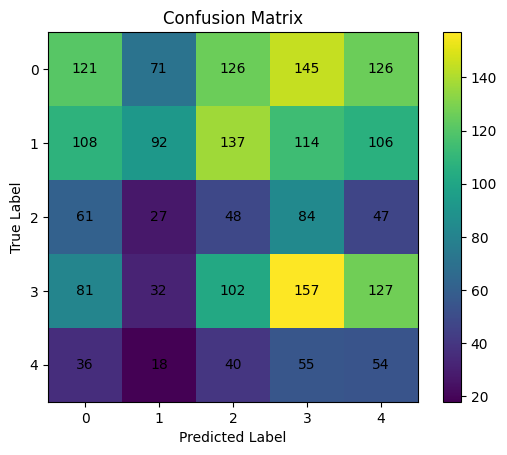

In [52]:
# Fit kmeans 
X = train_val_output.copy()
y = train_val_labels.copy()
classes = np.unique(y)  

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
k=5

silhouette_sum = 0
accuracy_sum = 0
f1_sum = 0
precision_sum = 0
recall_sum = 0
roc_auc_sum = 0
best_model = None
best_accuracy = 0
best_clusters_to_labels = None
for fold, (train_idx, val_idx) in enumerate(kfold_indices(len(X_scaled), k, random_state=42)):
    print(f"-----Fold {fold + 1}/{k}------")
    X_train, y_train = X_scaled[train_idx], y[train_idx]
    X_val, y_val = X_scaled[val_idx], y[val_idx]

    kmeans = KMeansScratch(n_clusters=5, max_iter=1000)
    kmeans.fit(X_scaled)
    train_pred = kmeans.predict(X_train)
    silhouette = silhouette_score(X_train, train_pred)
    print(f"Silhouette Score for fold {fold}: {silhouette:.4f}")
    silhouette_sum += silhouette
    mapped_train_labels, clusters_to_labels = map_clusters_to_labels(train_pred, y_train)

    val_labels = kmeans.predict(X_val)
    val_pred = use_mapping_to_get_test_labels(clusters_to_labels, val_labels)
    val_pred_soft = kmeans.predict_soft(X_val)
    val_pred_soft = map_soft_labels_to_classes(clusters_to_labels, val_pred_soft)
    

    accuracy = accuracy_score(y_val, val_pred)
    accuracy_sum += accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.4f}")

    f1 = f1_score(y_val, val_pred, average='macro')
    f1_sum += f1
    print(f"F1 Score for fold {fold}: {f1:.4f}")

    prec = precision_score(y_val, val_pred, average='macro')
    precision_sum += prec
    print(f"Precision Score for fold {fold}: {prec:.4f}")

    recall = recall_score(y_val, val_pred, average='macro')
    recall_sum += recall
    print(f"Recall Score for fold {fold}: {recall:.4f}")

    roc_auc = roc_auc_score(y_val, val_pred_soft, average='macro', multi_class='ovr')
    roc_auc_sum += roc_auc
    print(f"ROC AUC Score for fold {fold}: {roc_auc:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = kmeans
        best_clusters_to_labels = clusters_to_labels

    print("-" * 50)

print(f"Best Accuracy: {best_accuracy:.4f}")   
print(f"Average Silhouette Score for {k} folds: {silhouette_sum / k:.4f}")
print(f"Average Accuracy for {k} folds: {accuracy_sum / k:.4f}")
print(f"Average F1 Score for {k} folds: {f1_sum / k:.4f}")
print(f"Average Precision Score for {k} folds: {precision_sum / k:.4f}")
print(f"Average Recall Score for {k} folds: {recall_sum / k:.4f}")
print(f"Average ROC AUC Score for {k} folds: {roc_auc_sum / k:.4f}")

# Plot confusion matrix for the best model
train_val_pred = best_model.predict(X_scaled)
train_val_pred = use_mapping_to_get_test_labels(best_clusters_to_labels, train_val_pred)
cm = confusion_matrix_from_scratch(y_true=y, y_pred=train_val_pred.astype(int), classes=label_to_index.keys())
plot_cm(cm)


Shape of y_test_pred: (236,), test_labels: (236,)
Clustering accuracy for test: 28.39%
F1 Score for test: 0.2664
Precision Score for test: 0.3109
Recall Score for test: 0.2702
ROC AUC Score for test: 0.4788


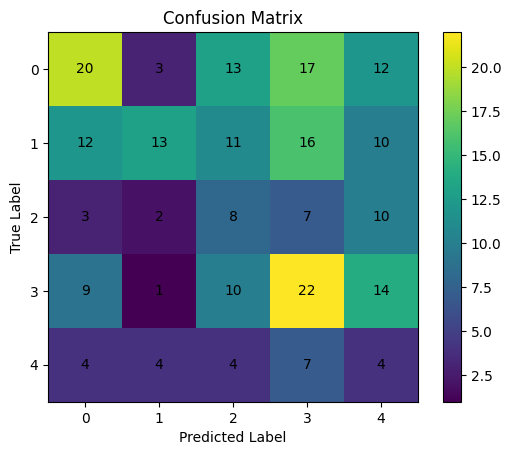

In [53]:
y_test_pred = best_model.predict(scaler.transform(test_output))
y_test_pred = use_mapping_to_get_test_labels(best_clusters_to_labels, y_test_pred)
y_test_pred_soft = best_model.predict_soft(scaler.transform(test_output))
y_test_pred_soft = map_soft_labels_to_classes(clusters_to_labels, y_test_pred_soft)
print(f"Shape of y_test_pred: {y_test_pred.shape}, test_labels: {test_labels.shape}")
acc = accuracy_score(test_labels, y_test_pred)
print(f"Clustering accuracy for test: {acc:.2%}")
f1 = f1_score(test_labels, y_test_pred, average='macro')
print(f"F1 Score for test: {f1:.4f}")
prec = precision_score(test_labels, y_test_pred, average='macro')
print(f"Precision Score for test: {prec:.4f}")
recall = recall_score(test_labels, y_test_pred, average='macro')
print(f"Recall Score for test: {recall:.4f}")
roc_auc = roc_auc_score(test_labels, y_test_pred_soft, average='macro', multi_class='ovr')
print(f"ROC AUC Score for test: {roc_auc:.4f}")
cm  = confusion_matrix_from_scratch(test_labels, y_test_pred.astype(int), classes=label_to_index.keys())
plot_cm(cm)

In [54]:
def visualize_clusters(
    true_labels: np.ndarray,
    y_pred: np.ndarray,
    index_to_label: Dict[int, str],
    cluster_to_labels: Dict[int, int],
    images: List[str],
    n_images: int = 16,
):
    """
    Visualize the clusters by showing images from each cluster.
    Args:
        true_labels (np.ndarray): True labels of the images.
        y_pred (np.ndarray): Predicted labels from clustering.
        cluster_to_labels (Dict[int, int]): Mapping from cluster IDs to true labels.
        images (List[str]): List of image paths.
        n_images (int): Number of images to display.
    """
    np.random.seed(42)  # For reproducibility
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(n_images):
        idx = np.random.randint(0, len(images))
        img = read_img(images[idx])
        ax = axes[i // 4, i % 4]
        ax.imshow(img)
        ax.set_title(f"True: {index_to_label[true_labels[idx]]}\nPred: {index_to_label[cluster_to_labels[y_pred[idx]]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

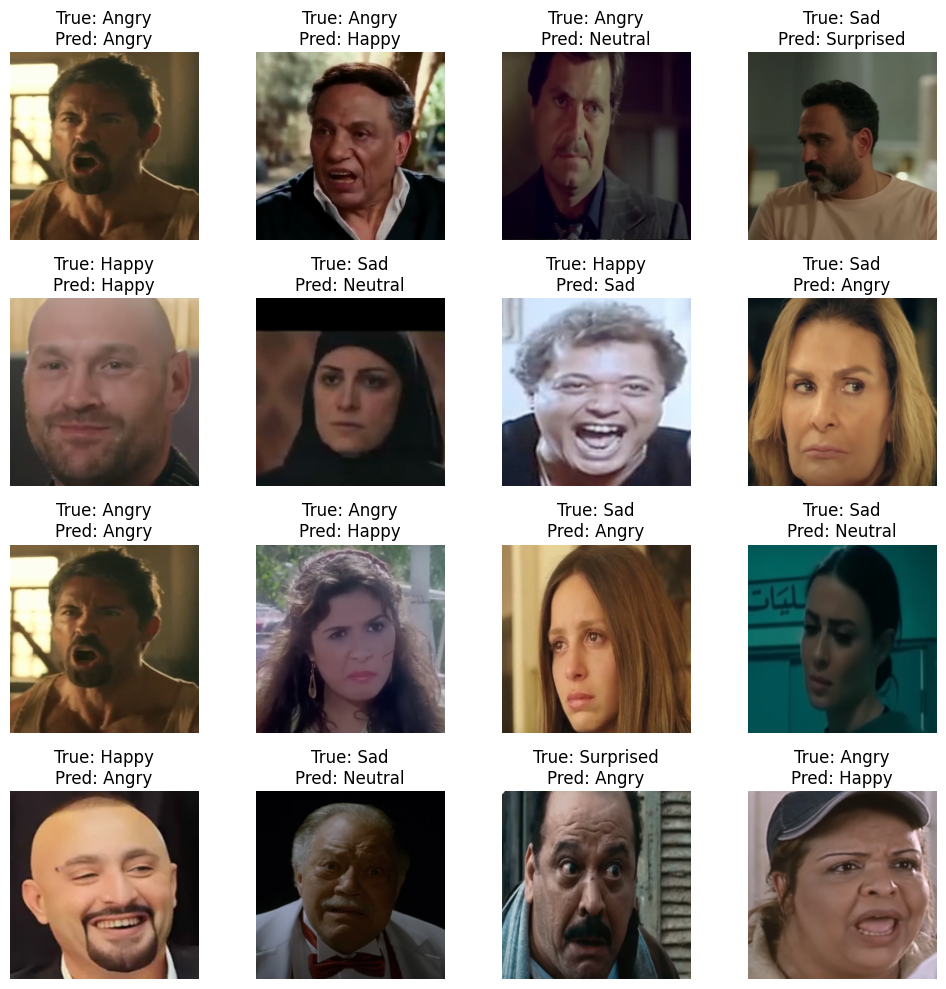

In [55]:
visualize_clusters(
    true_labels=test_labels,
    y_pred=y_test_pred,
    index_to_label=index_to_label,
    cluster_to_labels=best_clusters_to_labels,
    images=test_data,
    n_images=16
)

##### Use Mean of features as predefined centroids

Classes: [0 1 2 3 4]
Number of classes: 5
Centroids shape: (5, 128)
Fold sizes: [423, 423, 423, 423, 423]
-----Fold 1/5------
Distances between init centroids and cluster centers: [0. 0. 0. 0. 0.]
Silhouette Score for fold 0: 0.0402
Accuracy for fold 0: 0.2175
F1 Score for fold 0: 0.1918
Precision Score for fold 0: 0.2085
Recall Score for fold 0: 0.2390
ROC AUC Score for fold 0: 0.5488
--------------------------------------------------
-----Fold 2/5------
Distances between init centroids and cluster centers: [0. 0. 0. 0. 0.]
Silhouette Score for fold 1: 0.0437
Accuracy for fold 1: 0.2671
F1 Score for fold 1: 0.2184
Precision Score for fold 1: 0.2602
Recall Score for fold 1: 0.2630
ROC AUC Score for fold 1: 0.5625
--------------------------------------------------
-----Fold 3/5------
Distances between init centroids and cluster centers: [0. 0. 0. 0. 0.]
Silhouette Score for fold 2: 0.0439
Accuracy for fold 2: 0.2530
F1 Score for fold 2: 0.2133
Precision Score for fold 2: 0.2481
Recall S

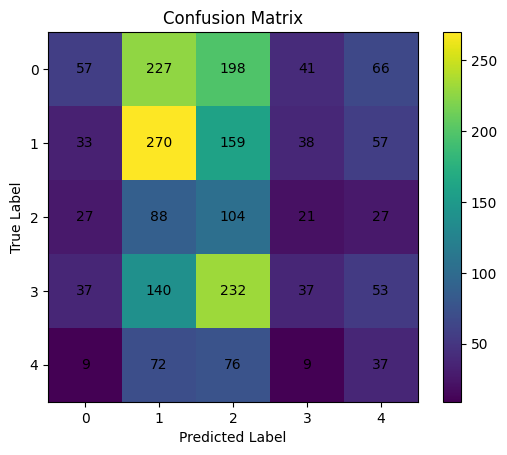

In [56]:
X = train_val_output.copy()
y = train_val_labels.copy()
classes = np.unique(y)  
print(f"Classes: {classes}")
print(f"Number of classes: {len(classes)}")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
k=5

init_centroids = np.array([X_scaled[y == cls].mean(axis=0) for cls in classes])
print(f"Centroids shape: {init_centroids.shape}")

silhouette_sum = 0
accuracy_sum = 0
f1_sum = 0
precision_sum = 0
recall_sum = 0
roc_auc_sum = 0
best_model = None
best_accuracy = 0
best_clusters_to_labels = None
for fold, (train_idx, val_idx) in enumerate(kfold_indices(len(X_scaled), k, random_state=42)):
    print(f"-----Fold {fold + 1}/{k}------")
    X_train, y_train = X_scaled[train_idx], y[train_idx]
    X_val, y_val = X_scaled[val_idx], y[val_idx]

    kmeans = KMeansScratch(
        n_clusters=len(classes),
        init_centroids=init_centroids,
        max_iter=0,
    )
    kmeans.fit(X_scaled)
    cluster_centers = kmeans.centroids
    # calculate distances between init centroids and the cluster centers
    distances = np.linalg.norm(init_centroids - cluster_centers, axis=1)
    print(f"Distances between init centroids and cluster centers: {distances}")

    train_pred = kmeans.predict(X_train)
    silhouette = silhouette_score(X_train, train_pred)
    print(f"Silhouette Score for fold {fold}: {silhouette:.4f}")
    silhouette_sum += silhouette
    mapped_train_labels, clusters_to_labels = map_clusters_to_labels(train_pred, y_train)

    val_labels = kmeans.predict(X_val)
    val_pred = use_mapping_to_get_test_labels(clusters_to_labels, val_labels)
    val_pred_soft = kmeans.predict_soft(X_val)
    val_pred_soft = map_soft_labels_to_classes(clusters_to_labels, val_pred_soft)
    

    accuracy = accuracy_score(y_val, val_pred)
    accuracy_sum += accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.4f}")

    f1 = f1_score(y_val, val_pred, average='macro')
    f1_sum += f1
    print(f"F1 Score for fold {fold}: {f1:.4f}")

    prec = precision_score(y_val, val_pred, average='macro')
    precision_sum += prec
    print(f"Precision Score for fold {fold}: {prec:.4f}")

    recall = recall_score(y_val, val_pred, average='macro')
    recall_sum += recall
    print(f"Recall Score for fold {fold}: {recall:.4f}")

    roc_auc = roc_auc_score(y_val, val_pred_soft, average='macro', multi_class='ovr')
    roc_auc_sum += roc_auc
    print(f"ROC AUC Score for fold {fold}: {roc_auc:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = kmeans
        best_clusters_to_labels = clusters_to_labels

    print("-" * 50)

print(f"Best Accuracy: {best_accuracy:.4f}")   
print(f"Average Silhouette Score for {k} folds: {silhouette_sum / k:.4f}")
print(f"Average Accuracy for {k} folds: {accuracy_sum / k:.4f}")
print(f"Average F1 Score for {k} folds: {f1_sum / k:.4f}")
print(f"Average Precision Score for {k} folds: {precision_sum / k:.4f}")
print(f"Average Recall Score for {k} folds: {recall_sum / k:.4f}")
print(f"Average ROC AUC Score for {k} folds: {roc_auc_sum / k:.4f}")

# Plot confusion matrix for the best model
train_val_pred = best_model.predict(X_scaled)
train_val_pred = use_mapping_to_get_test_labels(best_clusters_to_labels, train_val_pred)
cm = confusion_matrix_from_scratch(y_true=y, y_pred=train_val_pred.astype(int), classes=label_to_index.keys())
plot_cm(cm)


Shape of y_test_pred: (236,), test_labels: (236,)
Clustering accuracy for test: 23.73%
F1 Score for test: 0.2075
Precision Score for test: 0.2817
Recall Score for test: 0.2463
ROC AUC Score for test: 0.5285


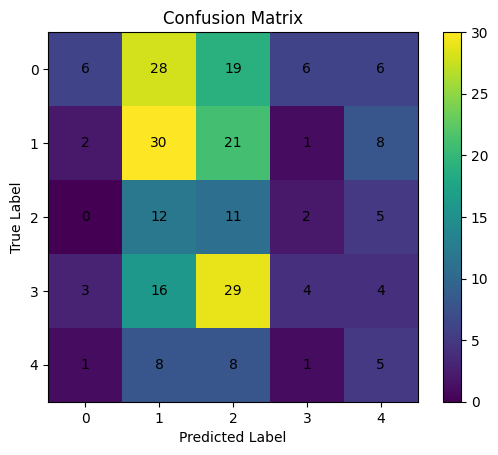

In [57]:
y_test_pred = best_model.predict(scaler.transform(test_output))
y_test_pred = use_mapping_to_get_test_labels(best_clusters_to_labels, y_test_pred)
y_test_pred_soft = best_model.predict_soft(scaler.transform(test_output))
y_test_pred_soft = map_soft_labels_to_classes(clusters_to_labels, y_test_pred_soft)
print(f"Shape of y_test_pred: {y_test_pred.shape}, test_labels: {test_labels.shape}")
acc = accuracy_score(test_labels, y_test_pred)
print(f"Clustering accuracy for test: {acc:.2%}")
f1 = f1_score(test_labels, y_test_pred, average='macro')
print(f"F1 Score for test: {f1:.4f}")
prec = precision_score(test_labels, y_test_pred, average='macro')
print(f"Precision Score for test: {prec:.4f}")
recall = recall_score(test_labels, y_test_pred, average='macro')
print(f"Recall Score for test: {recall:.4f}")
roc_auc = roc_auc_score(test_labels, y_test_pred_soft, average='macro', multi_class='ovr')
print(f"ROC AUC Score for test: {roc_auc:.4f}")
cm  = confusion_matrix_from_scratch(test_labels, y_test_pred.astype(int), classes=label_to_index.keys())
plot_cm(cm)

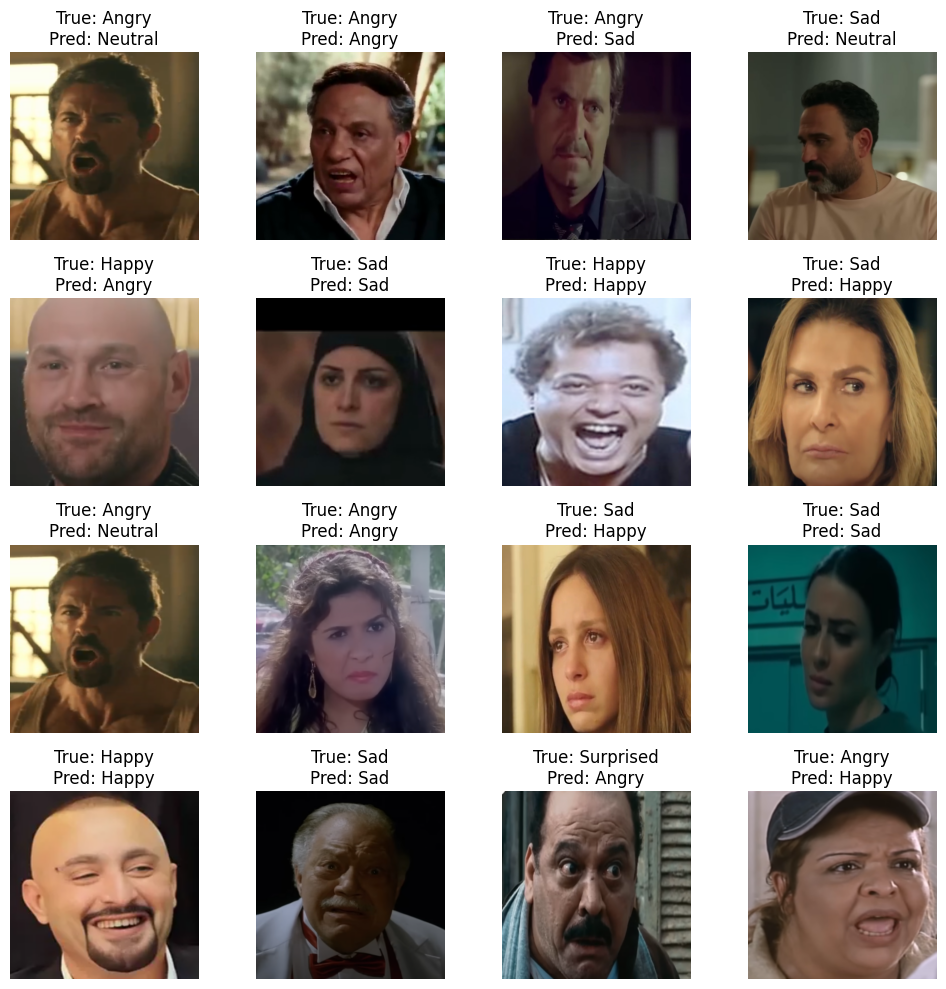

In [58]:
visualize_clusters(
    true_labels=test_labels,
    y_pred=y_test_pred,
    index_to_label=index_to_label,
    cluster_to_labels=best_clusters_to_labels,
    images=test_data,
    n_images=16
)